In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import os, sys
import json
from data_utils.data_utils import set_seed
set_seed(seed=42)
# compute the absolute path to your project root:
root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# insert it at the front of Python’s module search path:
sys.path.insert(0, root)

In [35]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

import torch
from torch.nn import functional as F
import torch.optim as optim

# Data pipeline
from data_utils.preprocess import (
    load_movielens, clean_and_filter,
    get_user_sequences, split_sequences,
    build_examples, pad_sequences,
    build_user_table, build_movie_table
)

# Dataset wrapper
from data_utils.datasets import MFTrainDataset, FeatureAwareDeepMFDataset

# Model and evaluation
from models.matrix_factorization import MatrixFactorization, DeepMF, FeatureAwareDeepMF
from evaluation import evaluate_ranking_model, evaluate_featureaware_model

In [36]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Running on", device)

Running on mps


## Data preprocessing

1.	Load raw data
Reads MovieLens “ratings”, “users” and “movies” files into pandas DataFrames.
2.	Clean & filter
• Drops ratings for nonexistent movies
• Keeps only ratings ≥ threshold (default 4)
• Converts Unix timestamps to datetime
3.	Build user timelines
Sorts each user’s interactions by time and collects their movie‑ID sequence.
4.	Split sequences
For each user with ≥ 3 events, chops their list into train, validation and test segments (by ratios 0.8/0.1/0.1).
5.	Construct training examples
For every prefix of length ≥ 2 in each user’s train split, emits one example comprising:
    - the prefix
    - the next (positive) item
    - K randomly sampled negatives (items the user never saw)
6.	Pad & mask
Right‐pad each prefix to a fixed length (max_len, default 50) with 0s, and build a matching binary mask.
7.	Build side‐feature tables
    - Users: bucket ages, drop ZIP, one‐hot encode gender & occupation
    - Movies: one‐hot encode genres, extract release year from title

At the end you have:
- A list of prefix / positive / negative examples, all padded for model input
- Dense user and movie feature tables for any tabular model components.

In [37]:
data_dir = "../data"
# 1) load & filter
ratings, users, movies = load_movielens(data_dir)
ratings, users, movies = clean_and_filter(ratings, users, movies, rating_threshold=4)

# 2) build per-user sequences & splits
user_seqs   = get_user_sequences(ratings)
user_splits = split_sequences(user_seqs, train_ratio=0.8, val_ratio=0.1)

# 3) global item set
all_movies = set(movies["MovieID"].unique())

# 4) build examples for train/val
train_exs = build_examples(user_splits, all_movies, K=5, split="train")
val_exs   = build_examples(user_splits, all_movies, K=5, split="val")
test_exs   = build_examples(user_splits, all_movies, K=5, split="test")

# 5) pad to fixed length
max_len   = 50
train_exs = pad_sequences(train_exs, max_len=max_len)
val_exs   = pad_sequences(val_exs, max_len=max_len)
test_exs  = pad_sequences(test_exs, max_len=max_len)

print(f"Train examples: {len(train_exs)},  Val examples: {len(val_exs)}")

Train examples: 445746,  Val examples: 51222


In [38]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
with open('train_data.json', 'w') as f:
    json.dump(train_exs, f, cls=NumpyEncoder)
with open('val_data.json', 'w') as f:
    json.dump(val_exs, f, cls=NumpyEncoder)
with open('test_data.json', 'w') as f:
    json.dump(test_exs, f, cls=NumpyEncoder)

In [6]:
train_exs[0]

{'UserID': 0,
 'prefix': [3117, 1250],
 'positive': 1672,
 'negatives': [1588, 3108, 3238, 3076, 3030],
 'padded_prefix': array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 3117, 1250]),
 'mask': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1])}

Each example in train_exs now has:
- `ex["padded_prefix"]` → np.array of shape (max_len,)
- `ex["mask"]`          → np.array of 0/1 mask of shape (max_len,)
- `ex["positive"]`      → scalar item ID
- `ex["negatives"]`     → list of K sampled negatives that are dense movie_ids

## Matrix Factorization (MF)

- **Goal**  
  Approximate the user–item interaction matrix \(R\) by two low‑rank factors:  
  $$R \approx U\,V^{T}$$

- **Embeddings**  
  - $U \in \mathbb{R}^{n_{\text{users}}\times k}$: each row $u_{i}$ is a $k$‑dimensional user vector  
  - $V \in \mathbb{R}^{n_{\text{items}}\times k}$: each row $v_{j}$ is a $k$‑dimensional item vector  

- **Prediction**  
  $$\hat r_{i,j} = u_{i}\cdot v_{j}
    = \sum_{\ell=1}^{k} U_{i,\ell}\,V_{j,\ell}$$



- **Training objectives**  
  - **Pairwise (BPR)**  
    $$\min_{U,V}\;
      -\sum_{(i,p,n)} \ln\sigma\bigl(\hat r_{i,p} - \hat r_{i,n}\bigr)$$

- **Why it works**  
  1. Learns compact “taste” factors without explicit features  
  2. Compresses a large, sparse matrix into dense vectors  
  3. Enables very fast inference via a simple dot‑product  

In [24]:
batch_size = 1024

train_ds = MFTrainDataset(train_exs, num_negatives=1)
val_ds   = MFTrainDataset(val_exs,   num_negatives=1)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)

num_users = len(users)
num_items = len(movies)

mf        = MatrixFactorization(num_users, num_items, embedding_dim=32).to(device)
optimizer = optim.Adam(mf.parameters(), lr=1e-3)

def bpr_loss(pos_scores, neg_scores):
    return -(pos_scores - neg_scores).sigmoid().log().mean()

print("Batches per epoch:", len(train_loader))


{'UserID': 0, 'prefix': [3117, 1250, 1672, 1009, 1768, 3339, 2735, 1189, 1176, 257, 907, 604], 'positive': 2623, 'negatives': [1713, 1301, 2890, 3617, 1350], 'padded_prefix': array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 3117, 1250, 1672, 1009, 1768, 3339,
       2735, 1189, 1176,  257,  907,  604]), 'mask': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])}
Batches per epoch: 436


In [8]:
unique_ids = {
    int(ex["positive"]) for ex in train_exs
}.union({
    int(ex["negatives"][0]) for ex in train_exs
})
len(unique_ids), max(unique_ids), min(unique_ids)

(3883, 3882, 0)

In [9]:
unique_ids = {
    int(ex["UserID"]) for ex in train_exs
}
len(unique_ids), max(unique_ids), min(unique_ids)

(6035, 6039, 0)

Epoch 1/3 — Train: 3.1637, Val: 3.0559
Epoch 2/3 — Train: 2.9054, Val: 2.9122
Epoch 3/3 — Train: 2.6680, Val: 2.7782


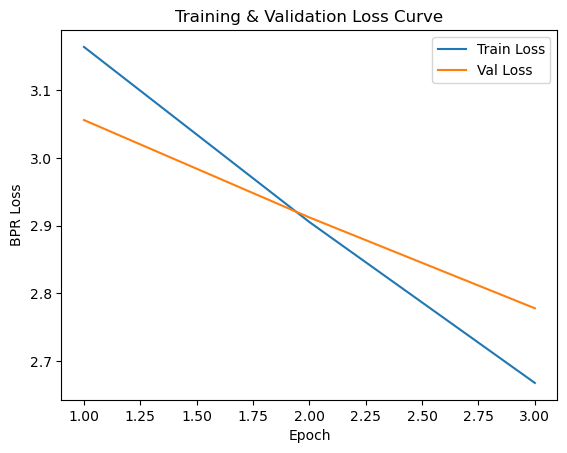

In [10]:
epochs = 3
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    # ——— train ———
    mf.train()
    tot_train = 0.0
    for user, pos, neg in train_loader:
        user, pos, neg = user.to(device), pos.to(device), neg.to(device)
        optimizer.zero_grad()
        loss = bpr_loss(mf(user, pos), mf(user, neg))
        loss.backward()
        optimizer.step()
        tot_train += loss.item()
    avg_train = tot_train / len(train_loader)
    train_losses.append(avg_train)

    # ——— val ———
    mf.eval()
    tot_val = 0.0
    with torch.no_grad():
        for user, pos, neg in val_loader:
            user, pos, neg = user.to(device), pos.to(device), neg.to(device)
            tot_val += bpr_loss(mf(user, pos), mf(user, neg)).item()
    avg_val = tot_val / len(val_loader)
    val_losses.append(avg_val)

    print(f"Epoch {epoch}/{epochs} — Train: {avg_train:.4f}, Val: {avg_val:.4f}")

# Cell 6: plot curves
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("BPR Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()

### Evaluation Procedure

#### 1. Metrics definitions
- **Hit@K**  
  Returns 1 if the true (positive) item is ranked $\le K$, else 0.
- **NDCG@K**  
  Returns $\displaystyle \frac{1}{\log_{2}(\mathrm{rank}+1)}$ if $\mathrm{rank}\le K$, else 0.
- **MRR** (Mean Reciprocal Rank)  
  $\displaystyle \mathrm{MRR} = \frac{1}{\mathrm{rank}}$
- **MAP** (Mean Average Precision)  
  For a single positive item, $\mathrm{AP} = \frac{1}{\mathrm{rank}}$

#### 2. Negative sampling
Given a user prefix (items in train + validation) and the global item set, sample $(\mathrm{candidate\_size} - 1)$ negatives uniformly from items the user hasn’t seen.

#### 3. Per‑user evaluation loop
For each user with at least one test item:  
1. **Build prefix** = `train_seq + val_seq`  
2. **Held‑out positive** = `test_seq[0]`  
3. **Sample negatives** (size = candidate_size – 1) excluding prefix & positive  
4. **Candidates** = `[positive] + negatives`  
5. **Score all candidates** in one forward pass:  
   ```python
   users_t = torch.tensor([user] * candidate_size, dtype=torch.long, device=device)
   items_t = torch.tensor(candidates,         dtype=torch.long, device=device)
   scores  = model(users_t, items_t).cpu().numpy()

In [11]:
metrics = evaluate_ranking_model(
    model=mf,
    user_splits=user_splits,
    global_items=all_movies,
    device=device,
    candidate_size=100,
    k=10
)

print("Evaluation Metrics:")
for name, val in metrics.items():
    print(f"- {name}: {val:.4f}")

Evaluation Metrics:
- Hit@10: 0.0938
- NDCG@10: 0.0416
- MRR: 0.0491
- MAP: 0.0491


Lets see which movies are similar to toy story

In [12]:
toy_story_emb = mf.item_embeddings.weight[0]               # shape: [32]   
item_embs = F.normalize(mf.item_embeddings.weight, dim=1)  # shape: [3883, 32]
toy_story_emb = toy_story_emb / toy_story_emb.norm()       # shape: [32]
similarities = item_embs @ toy_story_emb  # shape: [3883]
# Step 4: Get top-k most similar item indices (excluding itself if needed)
topk = torch.topk(similarities, k=10 + 1)
indices = topk.indices.tolist()
# Look them up in the movies DataFrame
similar_movies_df = movies[movies['MovieID'].isin(indices)]
# Optional: Sort by similarity score
scores = similarities[indices].tolist()
similar_movies_df['similarity'] = scores
similar_movies_df = similar_movies_df.sort_values(by='similarity', ascending=False)

print(similar_movies_df[['MovieID', 'Title', 'similarity']])

      MovieID                          Title  similarity
0           0               Toy Story (1995)    1.000000
380       380             Bad Company (1995)    0.563862
679       679            Country Life (1994)    0.551854
1197     1197        Army of Darkness (1993)    0.509585
1878     1878         West Side Story (1961)    0.490477
2098     2098                   Blade (1998)    0.487420
2235     2235       Love Is the Devil (1998)    0.486277
2668     2668           Assassination (1987)    0.482867
2878     2878              Goldfinger (1964)    0.478793
3236     3236               Bluebeard (1944)    0.471882
3521     3521  Lords of Flatbush, The (1974)    0.463763


/var/folders/bw/0d70cdj52fn0jt8hp7qxqj5r0000gn/T/ipykernel_95759/2661131617.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_movies_df['similarity'] = scores


## Fancier matrix factorization

We're now going to use an MLP instead of dot product. This brings us into deepMF territory. The set up is nearly identical so we can reuse the same data objects as before.

Epoch 1/3 | Train Loss: 0.4706 | Val Loss: 0.4308
Epoch 2/3 | Train Loss: 0.3070 | Val Loss: 0.3863
Epoch 3/3 | Train Loss: 0.2856 | Val Loss: 0.3788


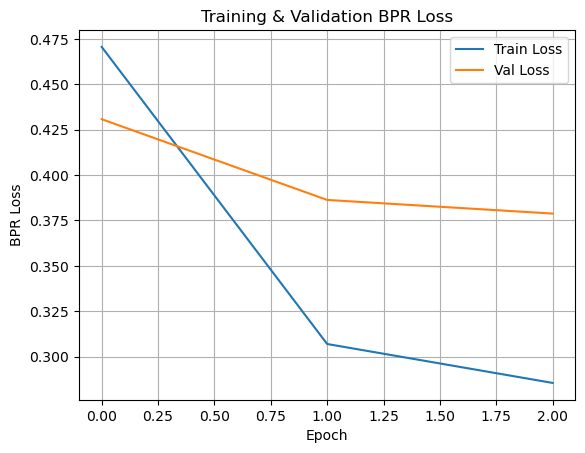

In [13]:
emb_dim = 32

train_losses, val_losses = [], []
model = DeepMF(num_users, num_items, emb_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 3

for epoch in range(epochs):
    # --- Training ---
    model.train()
    total_train_loss = 0.0

    for user, pos, neg in train_loader:
        user, pos, neg = user.to(device), pos.to(device), neg.to(device)

        optimizer.zero_grad()
        pos_score = model(user, pos)
        neg_score = model(user, neg)

        loss = -F.logsigmoid(pos_score - neg_score).mean()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for user, pos, neg in val_loader:
            user, pos, neg = user.to(device), pos.to(device), neg.to(device)

            pos_score = model(user, pos)
            neg_score = model(user, neg)

            val_loss = -F.logsigmoid(pos_score - neg_score).mean()
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("BPR Loss")
plt.title("Training & Validation BPR Loss")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
metrics = evaluate_ranking_model(
    model=model,
    user_splits=user_splits,
    global_items=all_movies,
    device=device,
    candidate_size=100,
    k=10
)

print("Evaluation Metrics:")
for name, val in metrics.items():
    print(f"- {name}: {val:.4f}")

Evaluation Metrics:
- Hit@10: 0.5360
- NDCG@10: 0.2926
- MRR: 0.2407
- MAP: 0.2407


In [15]:
from torch.nn import functional as F
toy_story_emb = model.item_embeddings.weight[0]               # shape: [32]   
item_embs = F.normalize(model.item_embeddings.weight, dim=1)  # shape: [3883, 32]
toy_story_emb = toy_story_emb / toy_story_emb.norm()       # shape: [32]
similarities = item_embs @ toy_story_emb  # shape: [3883]
# Step 4: Get top-k most similar item indices (excluding itself if needed)
topk = torch.topk(similarities, k=10 + 1)
indices = topk.indices.tolist()
# Look them up in the movies DataFrame
similar_movies_df = movies[movies['MovieID'].isin(indices)]
# Optional: Sort by similarity score
scores = similarities[indices].tolist()
similar_movies_df['similarity'] = scores
similar_movies_df = similar_movies_df.sort_values(by='similarity', ascending=False)

print(similar_movies_df[['MovieID', 'Title', 'similarity']])

      MovieID                                             Title  similarity
0           0                                  Toy Story (1995)    1.000000
187       187                                   Reckless (1995)    0.626344
437       437                         Dazed and Confused (1993)    0.609974
1797     1797                               Big Hit, The (1998)    0.593871
2592     2592                   It Came from Outer Space (1953)    0.568385
2998     2998  Women on the Verge of a Nervous Breakdown (1988)    0.554196
3135     3135                      Boys from Brazil, The (1978)    0.517042
3161     3161                           Odessa File, The (1974)    0.514553
3272     3272                             Born Yesterday (1950)    0.497850
3381     3381                             Grumpy Old Men (1993)    0.495095
3882     3882                             Contender, The (2000)    0.485137


/var/folders/bw/0d70cdj52fn0jt8hp7qxqj5r0000gn/T/ipykernel_95759/938465721.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_movies_df['similarity'] = scores


# Now lets add features to deepMF

In [16]:
user_feat, gender_vocab, occ_vocab = build_user_table(users)
movie_genre_vec, movie_year, genre_vocab = build_movie_table(movies)

In [17]:
train_ds = FeatureAwareDeepMFDataset(train_exs, user_feat, movie_genre_vec, movie_year)
val_ds   = FeatureAwareDeepMFDataset(val_exs,   user_feat, movie_genre_vec, movie_year)

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=512, shuffle=False, drop_last=False)


In [18]:
model = FeatureAwareDeepMF(
    num_users=len(user_feat),
    num_items=len(movie_genre_vec),
    num_genders=len(gender_vocab),
    num_occs=len(occ_vocab),
    num_genres=len(genre_vocab),
    emb_dim=32
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for u, pos, neg, gender, occ, year_pos, year_neg, age, _, genre_pos, genre_neg in train_loader:
        u, pos, neg = u.to(device), pos.to(device), neg.to(device)
        gender, occ = gender.to(device), occ.to(device)
        year_pos, year_neg = year_pos.to(device), year_neg.to(device)
        age = age.to(device)
        genre_pos, genre_neg = genre_pos.to(device), genre_neg.to(device)

        optimizer.zero_grad()
        pos_scores = model(u, pos, gender, occ, year_pos, age, genre_pos)
        neg_scores = model(u, neg, gender, occ, year_neg, age, genre_neg)

        loss = bpr_loss(pos_scores, neg_scores)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for u, pos, neg, gender, occ, year_pos, year_neg, age, _, genre_pos, genre_neg in val_loader:
            u, pos, neg = u.to(device), pos.to(device), neg.to(device)
            gender, occ = gender.to(device), occ.to(device)
            year_pos, year_neg = year_pos.to(device), year_neg.to(device)
            age = age.to(device)
            genre_pos, genre_neg = genre_pos.to(device), genre_neg.to(device)

            pos_scores = model(u, pos, gender, occ, year_pos, age, genre_pos)
            neg_scores = model(u, neg, gender, occ, year_neg, age, genre_neg)

            val_loss = bpr_loss(pos_scores, neg_scores)
            total_val_loss += val_loss.item()

    val_losses.append(total_val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

Epoch 1/5 | Train Loss: 0.3974 | Val Loss: 0.4013
Epoch 2/5 | Train Loss: 0.2834 | Val Loss: 0.3739
Epoch 3/5 | Train Loss: 0.2638 | Val Loss: 0.3765
Epoch 4/5 | Train Loss: 0.2503 | Val Loss: 0.3746
Epoch 5/5 | Train Loss: 0.2381 | Val Loss: 0.3800


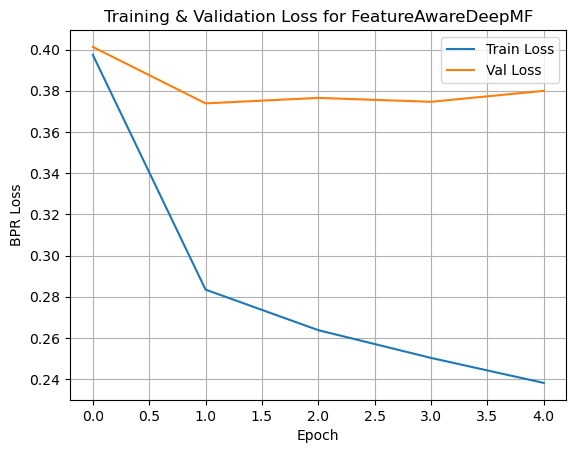

In [19]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("BPR Loss")
plt.title("Training & Validation Loss for FeatureAwareDeepMF")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
metrics = evaluate_featureaware_model(
    model,
    user_splits,
    set(movies["MovieID"]),
    user_feat,
    movie_genre_vec,
    movie_year,
    device=device
)
print(metrics)

{'Hit@10': np.float64(0.5529411764705883), 'NDCG@10': np.float64(0.30162377238830895), 'MRR': np.float64(0.247152452012204), 'MAP': np.float64(0.247152452012204)}


In [21]:
toy_story_emb = model.item_embeddings.weight[0]               # shape: [32]   
item_embs = F.normalize(model.item_embeddings.weight, dim=1)  # shape: [3883, 32]
toy_story_emb = toy_story_emb / toy_story_emb.norm()       # shape: [32]
similarities = item_embs @ toy_story_emb  # shape: [3883]
# Step 4: Get top-k most similar item indices (excluding itself if needed)
topk = torch.topk(similarities, k=10 + 1)
indices = topk.indices.tolist()
# Look them up in the movies DataFrame
similar_movies_df = movies[movies['MovieID'].isin(indices)]
# Optional: Sort by similarity score
scores = similarities[indices].tolist()
similar_movies_df['similarity'] = scores
similar_movies_df = similar_movies_df.sort_values(by='similarity', ascending=False)

print(similar_movies_df[['MovieID', 'Title', 'similarity']])

      MovieID                                        Title  similarity
0           0                             Toy Story (1995)    1.000000
424       424                         Bronx Tale, A (1993)    0.581540
680       680                  Operation Dumbo Drop (1995)    0.546793
917       917                 Foreign Correspondent (1940)    0.545485
1277     1277                           Real Genius (1985)    0.510163
1319     1319                 Bride of Frankenstein (1935)    0.496354
1562     1562                                 Mimic (1997)    0.487070
1785     1785                        Kissing a Fool (1998)    0.464942
1910     1910  Friday the 13th Part VI: Jason Lives (1986)    0.462963
2220     2220                           Player, The (1992)    0.447323
2970     2970                        Trading Places (1983)    0.447214


/var/folders/pt/4cr2zr794g717_kmql57h7qw0000gn/T/ipykernel_79467/2070559262.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_movies_df['similarity'] = scores
